# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.612466,False,3.105718
1,0.981007,True,5.361469
2,0.031391,False,0.666138
3,0.836242,True,5.019369
4,0.467961,False,1.026327
...,...,...,...
995,1.197681,True,7.625384
996,-0.543551,False,-2.741488
997,1.009332,True,5.334629
998,2.438408,True,6.895720


<AxesSubplot: xlabel='v0'>

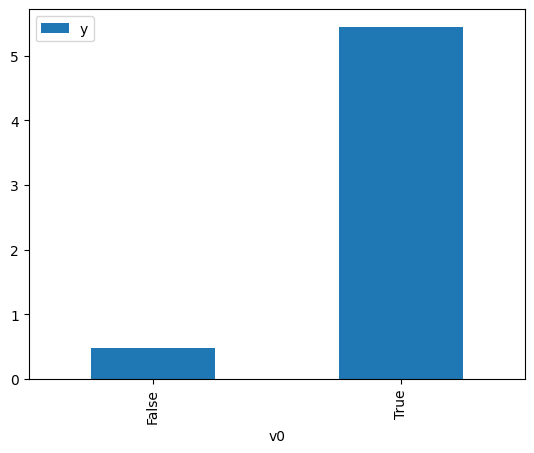

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

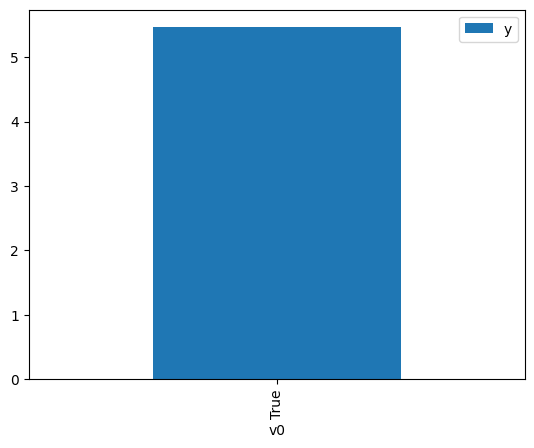

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.395953,False,2.064703,0.313537,3.189421
1,0.429158,False,0.575096,0.443169,2.256474
2,-0.936534,False,1.725734,0.635560,1.573415
3,1.750601,False,0.419830,0.271436,3.684105
4,1.218779,False,-0.351025,0.335844,2.977569
...,...,...,...,...,...
995,1.622978,False,1.045957,0.286174,3.494381
996,0.229341,False,1.812925,0.471647,2.120230
997,-0.247113,False,0.506506,0.539950,1.852023
998,-0.721224,False,-1.723152,0.606464,1.648904


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.157874,True,4.777706,0.472806,2.115031
1,1.410760,True,6.244303,0.688291,1.452874
2,-0.438335,True,3.328009,0.432912,2.309938
3,-0.169851,True,4.676376,0.471092,2.122729
4,2.741767,True,5.903058,0.825876,1.210836
...,...,...,...,...,...
995,-0.478332,True,3.624311,0.427281,2.340381
996,1.156694,True,7.074822,0.656155,1.524030
997,1.528706,True,7.709677,0.702638,1.423208
998,-0.219103,True,5.236946,0.464049,2.154945


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              9936.
Date:                Wed, 08 Feb 2023   Prob (F-statistic):                        0.00
Time:                        15:14:16   Log-Likelihood:                         -1406.0
No. Observations:                1000   AIC:                                      2816.
Df Residuals:                     998   BIC:                                      2826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0819      0.032     33.982      0.000       1.019       1.144
x2             4.9536      0.048    104.138      0.000       4.860       5.047
==============================================================================
Omnibus:                        1.632   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.442   Jarque-Bera (JB):                1.595
Skew:                           0.098   Prob(JB):                        0.450
Kurtosis:                       3.006   Cond. No.                         1.95
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""